In [1]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

# simulation grid
nu = 1
L = 35
nx = 1024//4
nt = 4000

# initial conditions used for demo
T  = 300
x = np.linspace( 0, L,  nx)
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

simulation_params = {'nu': nu, 'L': L, 'nx': nx, 'nt': nt}

# plot the result
def plot_KS(u,T,nx=nx,nt=nt):
    x = np.linspace( 0, L, nx)
    t = np.linspace( 0, T, nt)
    fig, ax = plt.subplots(figsize=(10,8))

    xx, tt = np.meshgrid(x, t)
    levels = np.linspace(-3.5, 3.5, 300)
    cs = ax.contourf(xx, tt, u, levels)
    fig.colorbar(cs)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

In [2]:
def full_integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
    dt = T/nt
    # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
    k = (2 * jnp.pi / L) * fftfreq(nx) * nx

    # solution mesh in real and Fourier space
    u      = jnp.empty((nt, nx), dtype=jnp.float64)
    u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
    u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

    # set initial condition in real and Fourier space
    u      = u     .at[0].set( u0 )
    u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
    u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

    # Fourier Transform of the linear and nonlinear operators
    FL = (k ** 2) - nu * (k ** 4)
    FN = - (1 / 2) * (1j) * k

    # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
    CN1 = (1 + (dt / 2) * FL)
    CN2 = 1 / (1 - (dt / 2) * FL)

    # first timestep (no advanced restarting, just Euler)
    u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

    # auxiliaries of first timestep
    u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
    u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

    # compute solution through time via finite difference method in Fourier space
    def finite_step(j, state):
        u, u_hat, u_hat2 = state
        # Cranck-Nicholson + Adams-Bashforth
        u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
        
        # go back to real space
        u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
        u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )
        return (u, u_hat, u_hat2)

    # compute solution through time via finite difference method in Fourier space
    u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2))[0]
    return jnp.real(u)
  
  return propagator

def integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
      dt = T/nt
      
      # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
      k = (2 * jnp.pi / L) * fftfreq(nx) * nx

      # Fourier Transform of the linear and nonlinear operators
      FL = (k ** 2) - nu * (k ** 4)
      FN = - (1 / 2) * (1j) * k

      # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
      CN1 = (1 + (dt / 2) * FL)
      CN2 = 1 / (1 - (dt / 2) * FL)

      # set initial condition in real and Fourier space
      u      = jnp.float64(u0)
      u_hat  = jnp.complex128((1 / nx) * fft(u0))
      u_hat2 = jnp.complex128((1 / nx) * fft(u0**2))

      # first timestep (no advanced restarting, just Euler)
      u_hatL  = CN2 * ( CN1 * u_hat + FN * u_hat2 * dt)
      uL      = nx * jnp.real(ifft(u_hatL))
      u_hat2L = (1/nx) * fft(uL**2)

      # compute solution through time via finite difference method in Fourier space
      def finite_step(j, state):
          u, u_hat, u_hat2, u_hat2L = state

          # Cranck-Nicholson + Adams-Bashforth
          u_hatN =  CN2 * ( CN1 * u_hat + ( 1.5 * FN * u_hat2 - 0.5 * FN * u_hat2L ) * dt)
          
          # go back to real space
          uN      = nx * jnp.real(ifft(u_hatN))
          u_hat2N = (1/nx) * fft(uN**2)

          return (uN, u_hatN, u_hat2N, u_hat2)

      # compute solution through time via finite difference method in Fourier space
      u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2, u_hat2L))[0]
      return jnp.real(u)
  
  return propagator

full_propagator = full_integrator(**simulation_params)
propagator = integrator(**simulation_params)

In [3]:
u = full_propagator(u0,T)

In [4]:
uend = propagator(u0,T)

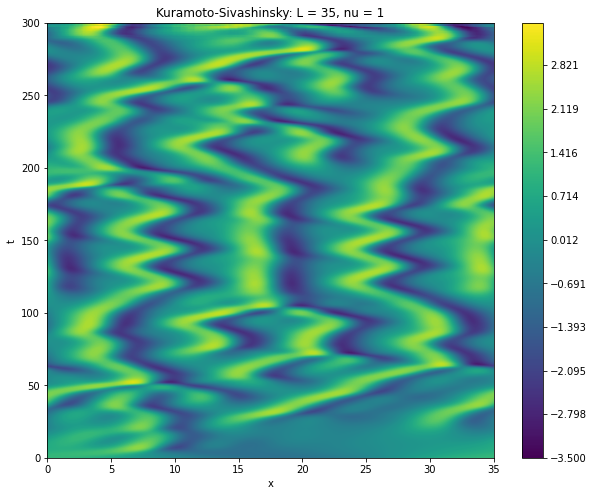

In [5]:
plot_KS(u,T)

In [ ]:
from ks import PO_autocorrelation

a, b, diff = PO_autocorrelation(u,nt)

plt.contourf(diff)
plt.colorbar()

7.654376833146577
550 727


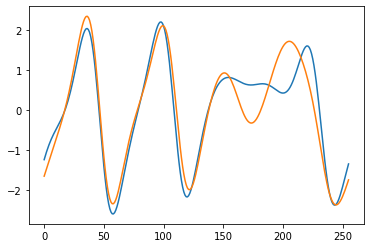

In [ ]:
plt.plot(u[a])
plt.plot(u[b])
print(np.linalg.norm(u[a] - u[b]))
print(a,b)

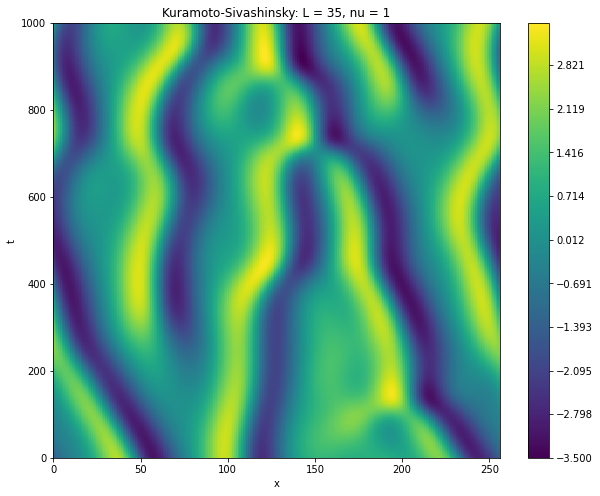

In [ ]:
new_T = T * (b-a)/nt
u_new = full_propagator(u[a],new_T)
plot_KS(u_new, new_T)
plt.pcolor(u_new)

In [ ]:
# diff = np.linalg.norm(u_new[:,np.newaxis] - u_new[np.newaxis,:],axis=-1)
# X, Y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
# diff[abs(X-Y)<0.1] += np.inf
# a = np.argmin(diff) % nt
# b = np.argmin(diff) // nt
# a, b = min(a,b), max(a,b)
# plt.plot(u_new[a])
# plt.plot(u_new[b])
# print(np.linalg.norm(u_new[a] - u_new[b]))
# print(a,b)

In [ ]:
# new_T *= (b-a)/nt
# u_new = full_propagator(u_new[a],new_T)
# plot_KS(u_new, new_T)
# plt.pcolor(u_new)

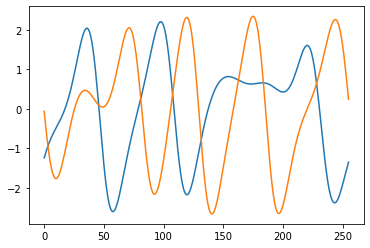

In [ ]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [ ]:
@jit
def residual(u0):
    uf = propagator(u0,new_T)
    return (u0 - uf) / jnp.linalg.norm(u0)

|F(x)| = 1.8277977509336263


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  


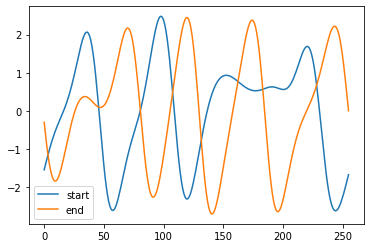

1: |F(x)| = 1.8082469982, |s| = 0.01, |p| = 204.13580, |u| = 22.04802


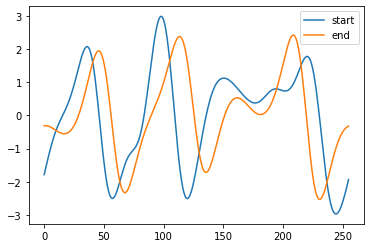

2: |F(x)| = 1.1003737492, |s| = 0.010108, |p| = 329.12084, |u| = 23.97864


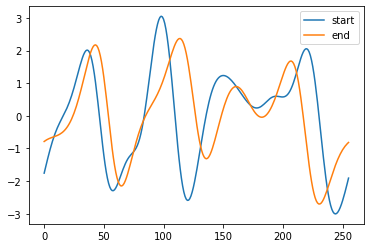

3: |F(x)| = 1.0292393250, |s| = 0.016611, |p| = 106.61515, |u| = 24.21439


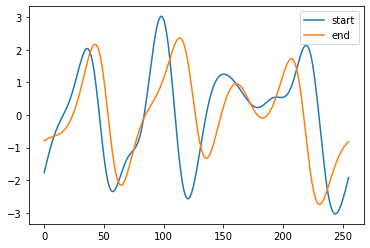

4: |F(x)| = 1.0147937078, |s| = 0.017759, |p| = 30.04518, |u| = 24.40404


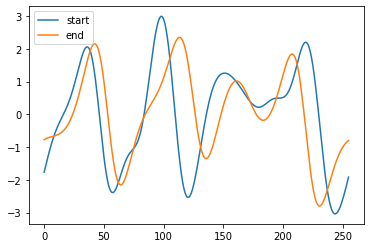

5: |F(x)| = 1.0003851636, |s| = 0.018012, |p| = 29.46569, |u| = 24.51123


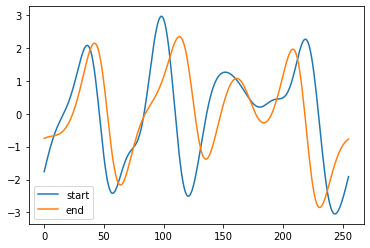

6: |F(x)| = 0.9834411682, |s| = 0.018271, |p| = 27.59421, |u| = 24.57684


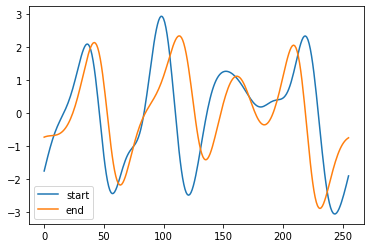

7: |F(x)| = 0.9642885363, |s| = 0.018586, |p| = 25.45699, |u| = 24.62920


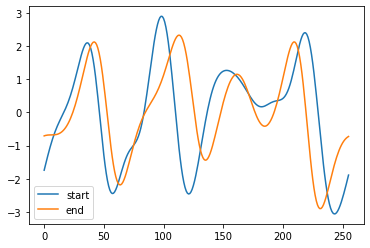

8: |F(x)| = 0.9438657304, |s| = 0.018955, |p| = 23.60546, |u| = 24.67654


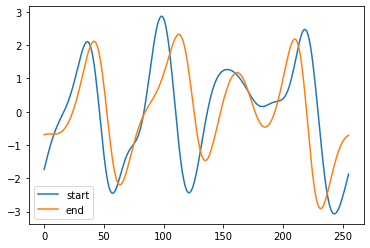

9: |F(x)| = 0.9228192163, |s| = 0.019365, |p| = 21.94107, |u| = 24.72106


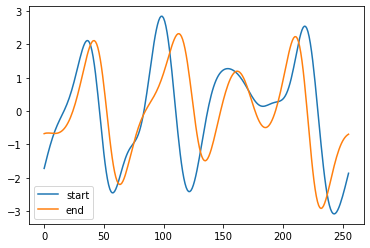

10: |F(x)| = 0.9015461733, |s| = 0.019807, |p| = 20.40928, |u| = 24.76336


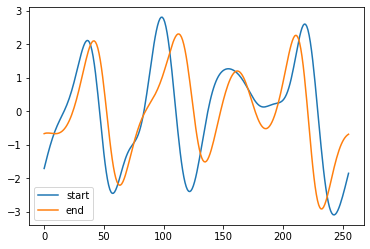

11: |F(x)| = 0.8802960321, |s| = 0.020274, |p| = 19.00061, |u| = 24.80345


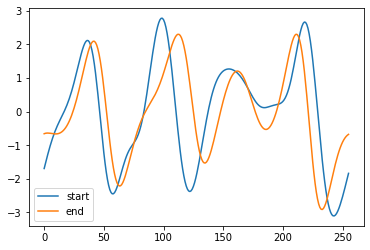

12: |F(x)| = 0.8592407084, |s| = 0.020763, |p| = 17.71822, |u| = 24.84101


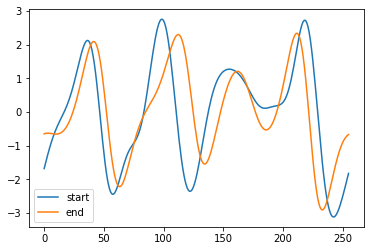

13: |F(x)| = 0.8385201231, |s| = 0.021272, |p| = 16.56566, |u| = 24.87545


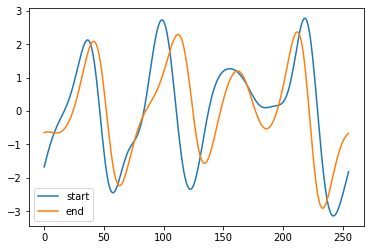

14: |F(x)| = 0.8182732158, |s| = 0.021798, |p| = 15.54456, |u| = 24.90592


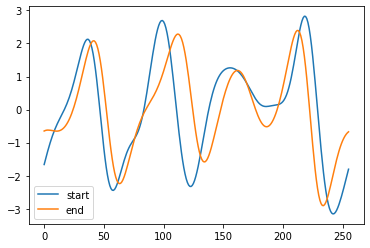

15: |F(x)| = 0.7986618559, |s| = 0.022337, |p| = 14.65595, |u| = 24.93135


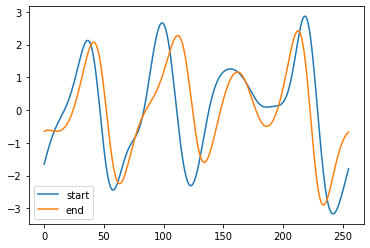

16: |F(x)| = 0.7798927851, |s| = 0.022886, |p| = 13.90296, |u| = 24.95040


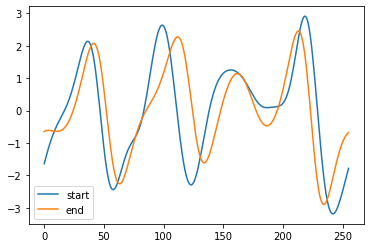

17: |F(x)| = 0.7622413036, |s| = 0.023437, |p| = 13.29412, |u| = 24.96146


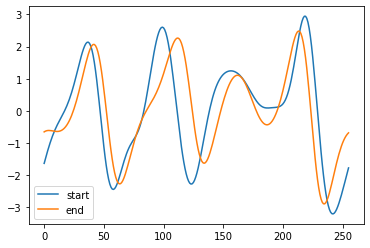

18: |F(x)| = 0.7460796733, |s| = 0.023979, |p| = 12.84740, |u| = 24.96258


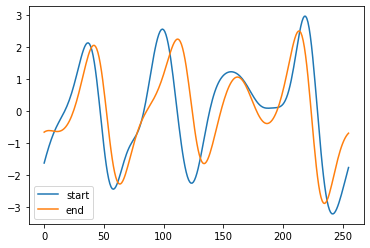

19: |F(x)| = 0.7319131539, |s| = 0.024499, |p| = 12.59570, |u| = 24.95144


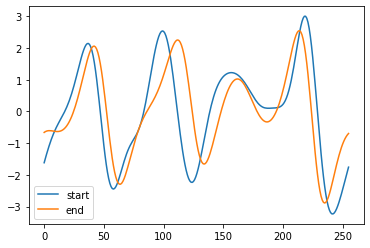

20: |F(x)| = 0.7204281836, |s| = 0.024973, |p| = 12.59470, |u| = 24.92521


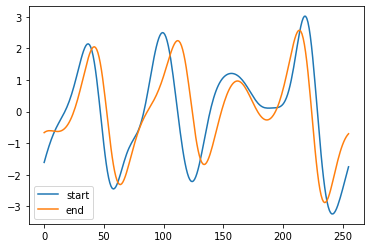

21: |F(x)| = 0.7125645701, |s| = 0.025371, |p| = 12.93626, |u| = 24.88027


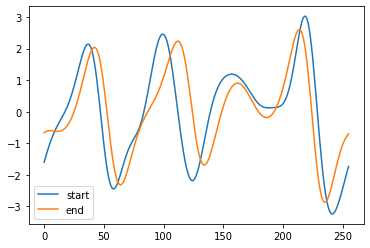

22: |F(x)| = 0.7096508982, |s| = 0.025651, |p| = 13.78208, |u| = 24.81139


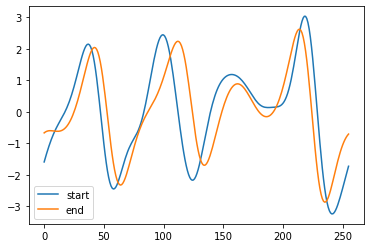

23: |F(x)| = 0.7054863033, |s| = 0.012878, |p| = 15.49617, |u| = 24.75943


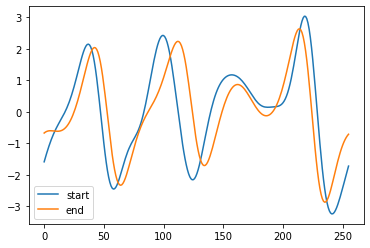

24: |F(x)| = 0.7018891046, |s| = 0.012954, |p| = 16.33124, |u| = 24.69987


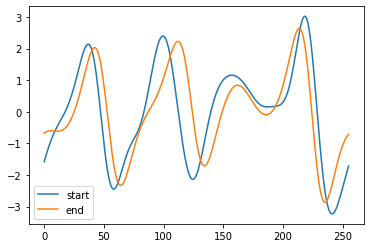

25: |F(x)| = 0.6989442882, |s| = 0.013021, |p| = 17.37458, |u| = 24.63148


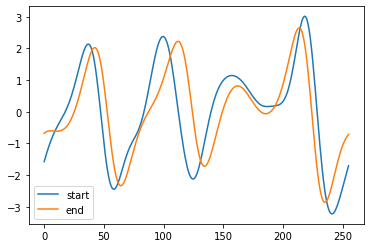

26: |F(x)| = 0.6967691265, |s| = 0.013075, |p| = 18.71681, |u| = 24.55241


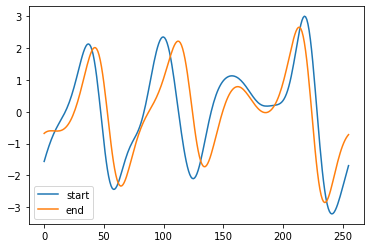

27: |F(x)| = 0.6955274950, |s| = 0.013116, |p| = 20.54684, |u| = 24.45948


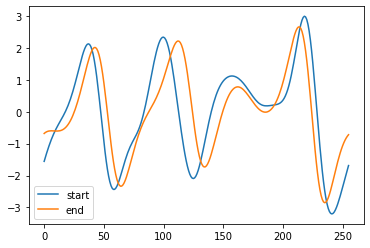

28: |F(x)| = 0.6931382490, |s| = 0.0065698, |p| = 23.30655, |u| = 24.40262


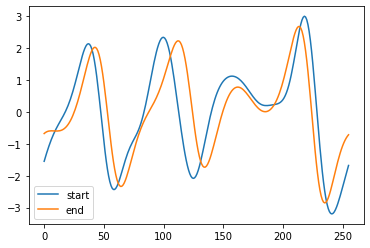

29: |F(x)| = 0.6908560582, |s| = 0.0065925, |p| = 24.46991, |u| = 24.34154


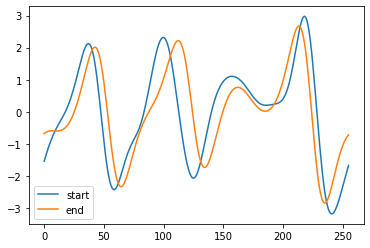

30: |F(x)| = 0.6886888118, |s| = 0.0066142, |p| = 25.88261, |u| = 24.27543


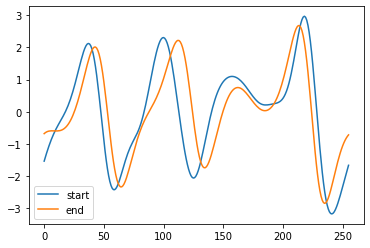

31: |F(x)| = 0.6866416600, |s| = 0.0066351, |p| = 27.66514, |u| = 24.20308


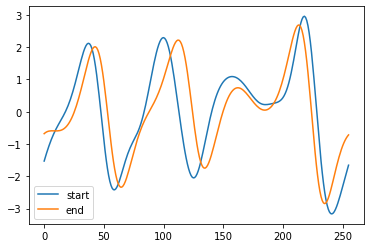

32: |F(x)| = 0.6847111802, |s| = 0.0066548, |p| = 30.02381, |u| = 24.12260


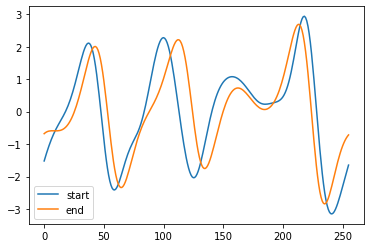

33: |F(x)| = 0.6828683078, |s| = 0.0066736, |p| = 33.33986, |u| = 24.03090


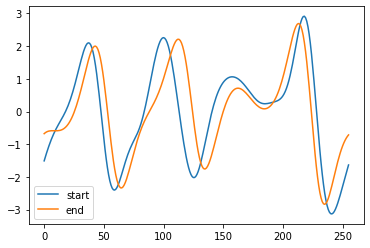

34: |F(x)| = 0.6810015447, |s| = 0.0066916, |p| = 38.39330, |u| = 23.92241


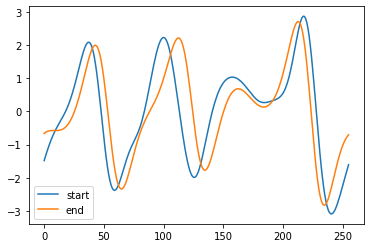

35: |F(x)| = 0.6807667668, |s| = 0.01342, |p| = 47.00369, |u| = 23.65273


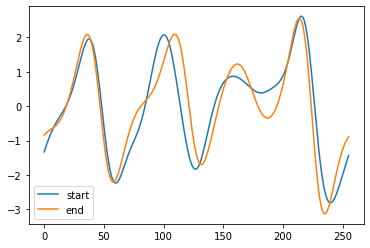

36: |F(x)| = 0.4446872357, |s| = 0.013425, |p| = 249.90311, |u| = 22.25510


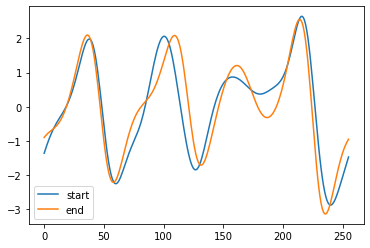

37: |F(x)| = 0.4213869108, |s| = 0.041103, |p| = 12.26727, |u| = 22.44938


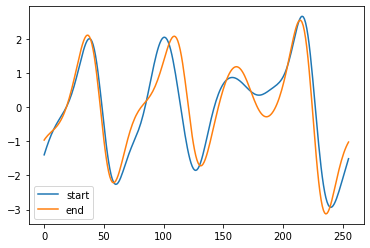

38: |F(x)| = 0.3971902289, |s| = 0.043376, |p| = 12.79861, |u| = 22.65439


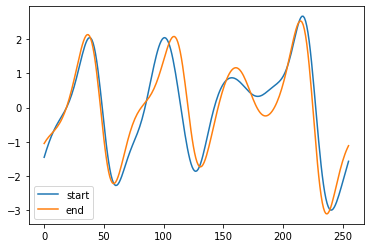

39: |F(x)| = 0.3719467183, |s| = 0.046018, |p| = 14.04828, |u| = 22.86664


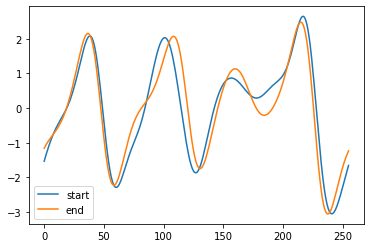

40: |F(x)| = 0.3455080988, |s| = 0.049141, |p| = 16.74107, |u| = 23.07935


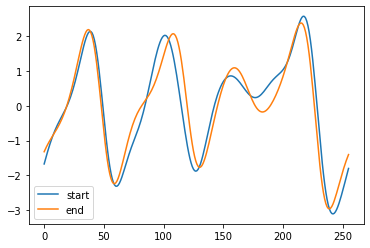

41: |F(x)| = 0.3180568135, |s| = 0.052902, |p| = 23.11899, |u| = 23.27788


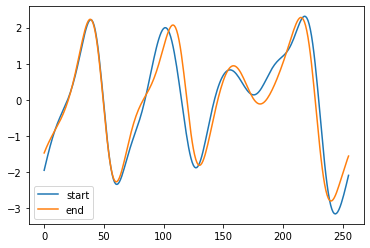

42: |F(x)| = 0.3007299027, |s| = 0.057468, |p| = 42.73344, |u| = 23.43361


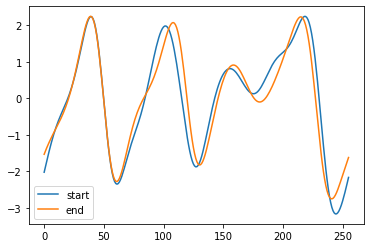

43: |F(x)| = 0.2989236270, |s| = 0.015195, |p| = 44.89135, |u| = 23.38870


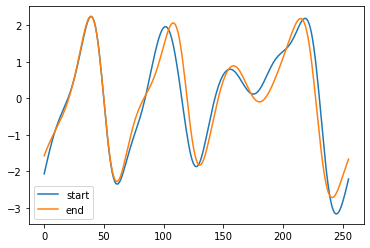

44: |F(x)| = 0.2979126758, |s| = 0.0076432, |p| = 56.37458, |u| = 23.34817


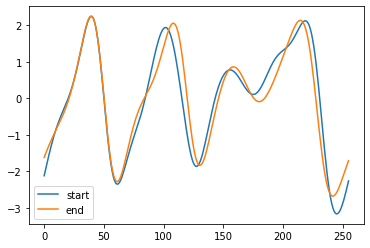

45: |F(x)| = 0.2977595505, |s| = 0.0076692, |p| = 69.26340, |u| = 23.29276


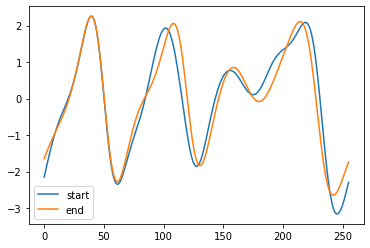

46: |F(x)| = 0.2975867698, |s| = 0.0038366, |p| = 91.55043, |u| = 23.24999


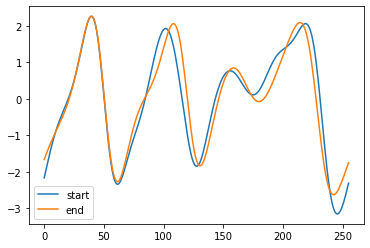

47: |F(x)| = 0.2974430004, |s| = 0.0019194, |p| = 121.06692, |u| = 23.21918


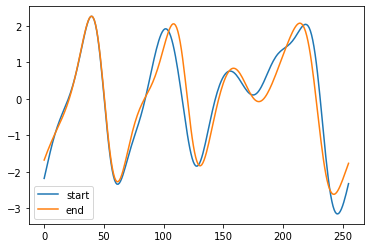

48: |F(x)| = 0.2973379637, |s| = 0.00096016, |p| = 157.61059, |u| = 23.19806


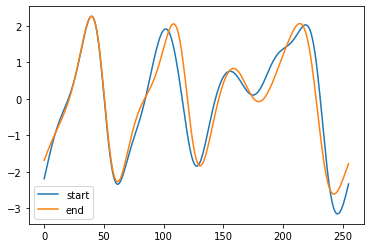

49: |F(x)| = 0.2972667284, |s| = 0.00048025, |p| = 199.02710, |u| = 23.18428


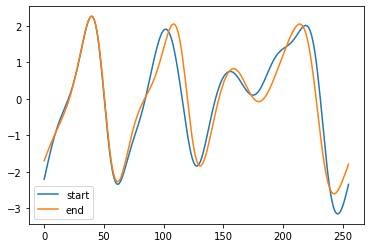

50: |F(x)| = 0.2972275109, |s| = 0.00048037, |p| = 240.58787, |u| = 23.16742


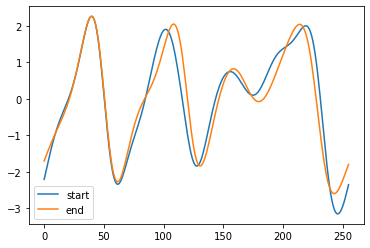

51: |F(x)| = 0.2972019060, |s| = 0.00024021, |p| = 321.67269, |u| = 23.15589


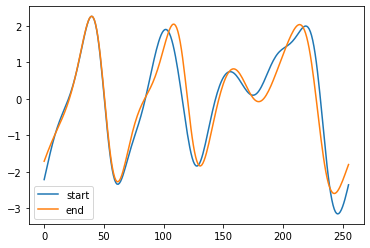

52: |F(x)| = 0.2971854987, |s| = 0.00012012, |p| = 419.40421, |u| = 23.14825


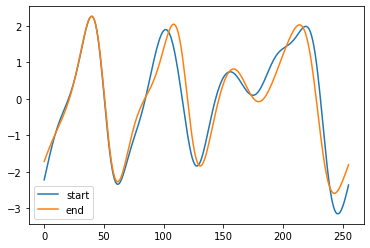

53: |F(x)| = 0.2971798439, |s| = 0.00012012, |p| = 526.19323, |u| = 23.13860


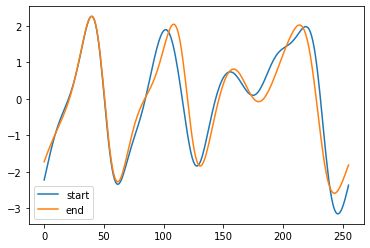

54: |F(x)| = 0.2971780998, |s| = 6.0063e-05, |p| = 774.60263, |u| = 23.13142


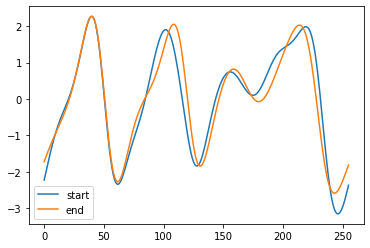

55: |F(x)| = 0.2971760399, |s| = 1.5016e-05, |p| = 1200.18930, |u| = 23.12860


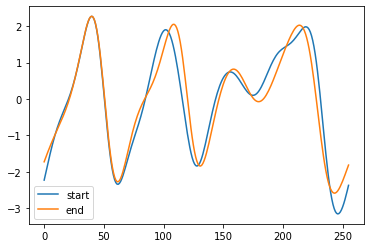

56: |F(x)| = 0.2971754805, |s| = 1.5016e-05, |p| = 1533.82119, |u| = 23.12500


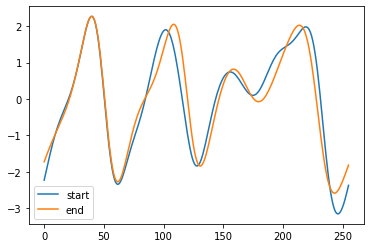

57: |F(x)| = 0.2971749516, |s| = 3.754e-06, |p| = 2382.45570, |u| = 23.12359


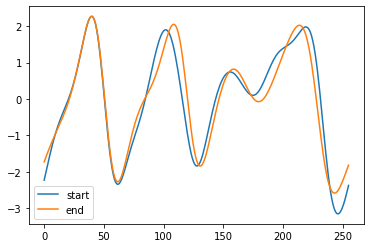

58: |F(x)| = 0.2971747908, |s| = 3.754e-06, |p| = 3043.65652, |u| = 23.12179


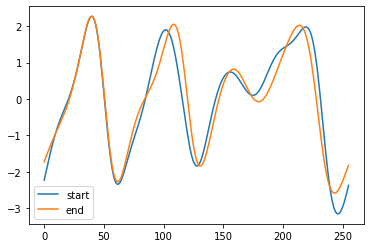

59: |F(x)| = 0.2971746552, |s| = 9.385e-07, |p| = 4719.52373, |u| = 23.12109


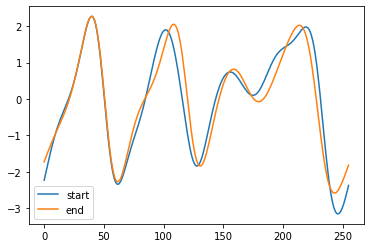

60: |F(x)| = 0.2971746082, |s| = 9.385e-07, |p| = 6009.34642, |u| = 23.12020


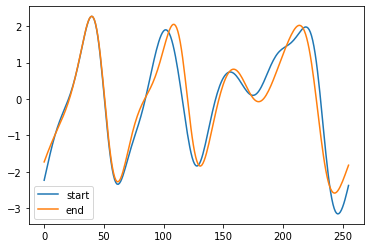

61: |F(x)| = 0.2971746050, |s| = 4.6925e-07, |p| = 9220.59050, |u| = 23.11951


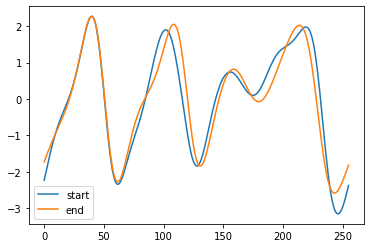

62: |F(x)| = 0.2971745947, |s| = 1.1731e-07, |p| = 15649.38281, |u| = 23.11922


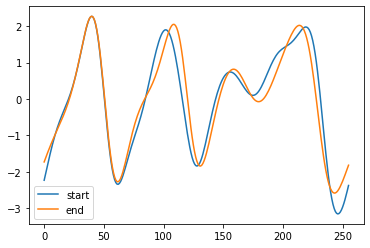

63: |F(x)| = 0.2971745897, |s| = 5.8657e-08, |p| = 22243.43103, |u| = 23.11902


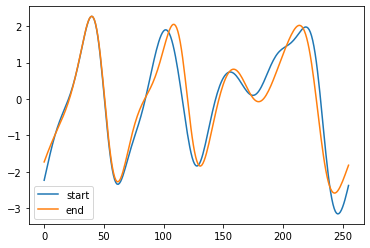

64: |F(x)| = 0.2971745872, |s| = 2.9328e-08, |p| = 31761.10349, |u| = 23.11887


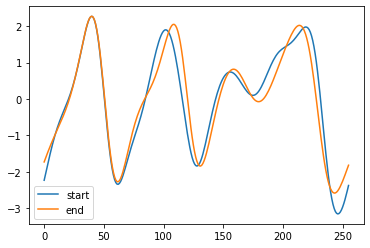

65: |F(x)| = 0.2971745862, |s| = 1.4664e-08, |p| = 45741.53344, |u| = 23.11876


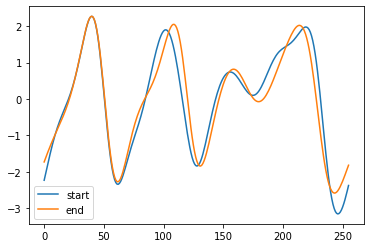

66: |F(x)| = 0.2971745857, |s| = 7.3321e-09, |p| = 66979.02402, |u| = 23.11869


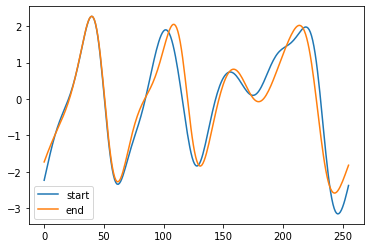

67: |F(x)| = 0.2971745857, |s| = 3.666e-09, |p| = 101485.98146, |u| = 23.11863


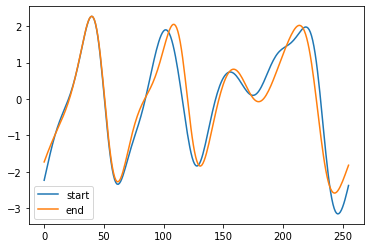

68: |F(x)| = 0.2971745855, |s| = 9.1651e-10, |p| = 166473.26518, |u| = 23.11860


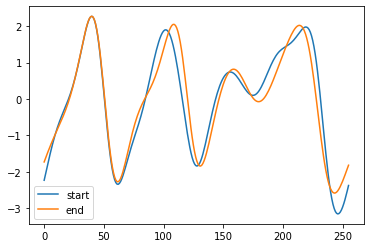

69: |F(x)| = 0.2971745855, |s| = 4.5825e-10, |p| = 225773.00505, |u| = 23.11859


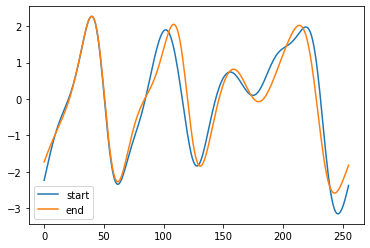

70: |F(x)| = 0.2971745855, |s| = 2.2913e-10, |p| = 297682.01894, |u| = 23.11857


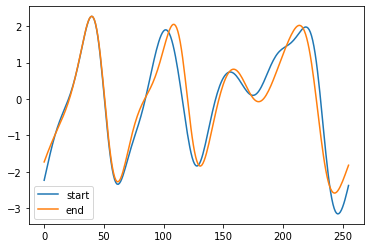

71: |F(x)| = 0.2971745854, |s| = 2.2913e-10, |p| = 376803.61215, |u| = 23.11856


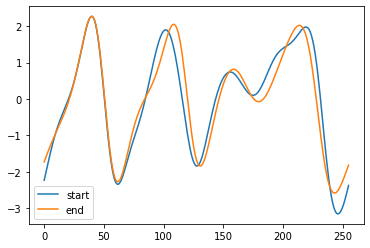

72: |F(x)| = 0.2971745854, |s| = 1.1456e-10, |p| = 567853.11685, |u| = 23.11855


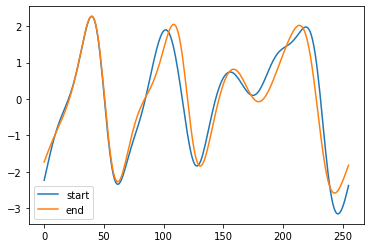

73: |F(x)| = 0.2971745854, |s| = 2.8641e-11, |p| = 918951.98219, |u| = 23.11855


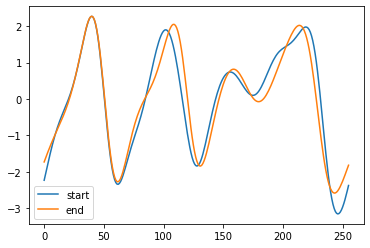

74: |F(x)| = 0.2971745854, |s| = 1.432e-11, |p| = 1225517.73202, |u| = 23.11854


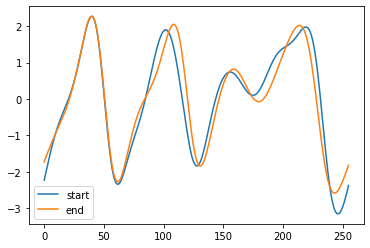

75: |F(x)| = 0.2971745854, |s| = 1.432e-11, |p| = 1576129.76025, |u| = 23.11854


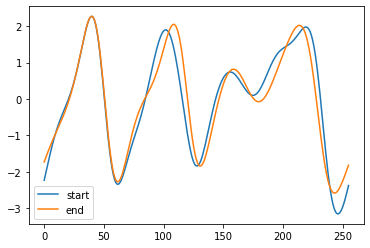

76: |F(x)| = 0.2971745854, |s| = 3.5801e-12, |p| = 2493643.95055, |u| = 23.11854


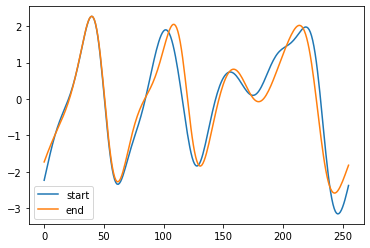

77: |F(x)| = 0.2971745854, |s| = 3.5801e-12, |p| = 3239553.23648, |u| = 23.11854


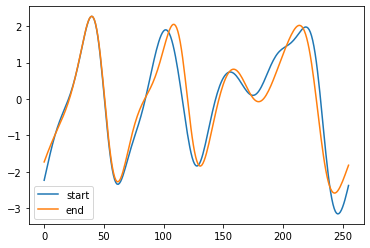

78: |F(x)| = 0.2971745854, |s| = 8.9503e-13, |p| = 5298638.43809, |u| = 23.11854


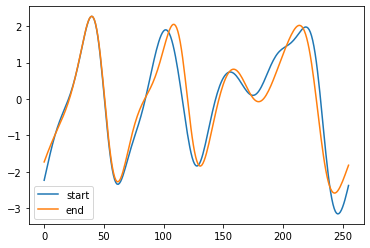

79: |F(x)| = 0.2971745854, |s| = 3.3342e-21, |p| = 7159462.46248, |u| = 23.11854


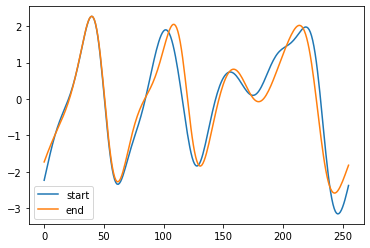

80: |F(x)| = 0.2971745854, |s| = 4.1678e-22, |p| = 7159461.86838, |u| = 23.11854


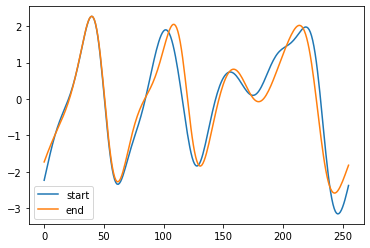

81: |F(x)| = 0.2971745854, |s| = 4.1678e-22, |p| = 7159456.59612, |u| = 23.11854
Residual 0.05206848824933169


In [ ]:
def JAX_newton_krylov(res, u0, tol=1e-5, iter=200, s0 = 1e-2):
    u = u0
    Jacobian_shape = (len(u0.flatten()), len(u0.flatten()))

    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    i = 1
    magold = magF
    conv = []
    try: 
        while magF > tol and i < iter:
            J = linalg.LinearOperator(Jacobian_shape, matvec=lambda v: (jax.jvp(res, (u.flatten(),), (v,)))[1])
            p, errorcode = linalg.lgmres(J,F.flatten(),inner_m=40,outer_k=20)
            p = p.reshape(u.shape)
            s = s0 * magold/magF
            while not jnp.linalg.norm(res(u - s*p)) < (1-0.01*s)*magF:
                s /= 2
            u -= s*p
            plt.plot(u,label='start')
            plt.plot(propagator(u,new_T), label='end')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.title(f'u(0) and u({new_T:.3f}) at iteration {i}')
            plt.legend()
            plt.show()
            F = res(u)
            #magold = magF
            magF = np.linalg.norm(F)
            print(f"{i}: |F(x)| = {magF:.10f}, |s| = {s:.5g}, |p| = {np.linalg.norm(p):.5f}, |u| = {np.linalg.norm(u):.5f}")
            conv.append((magF, s, np.linalg.norm(p), np.linalg.norm(u)))
            i += 1
    except KeyboardInterrupt:
        pass
    return u, conv

# solve
guess = u_new[0] #State(u[a],new_T)
sol, conv = JAX_newton_krylov(residual, guess)
print('Residual', abs(residual(sol)).max())

In [ ]:
RPO = full_propagator(sol,new_T)

53.1


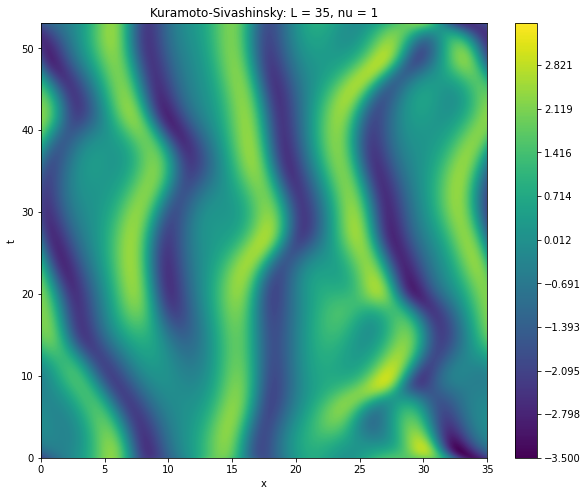

In [ ]:
print(new_T)
plot_KS(RPO, new_T)

|F(x)| = 0.29717458543144265


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  


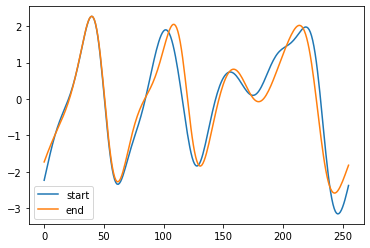

1: |F(x)| = 0.2971745854, |s| = 5.294e-23, |p| = 7159458.62889, |u| = 23.11854
Residual 0.05206848824933169


In [ ]:
sol2, conv2 = JAX_newton_krylov(residual, sol, s0=1)
print('Residual', abs(residual(sol)).max())

53.1


[]

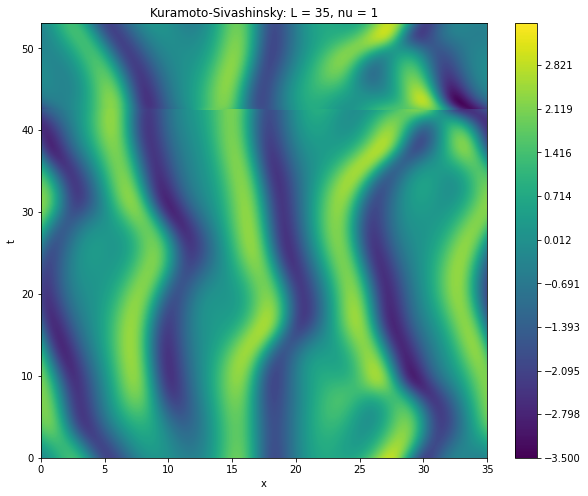

In [ ]:
RPO2 = full_propagator(sol2,new_T)
print(new_T)
plot_KS(np.roll(RPO,-200, axis=0), new_T)
plt.plot()